In [32]:
# importing required modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [33]:
# reading the dataset
df = pd.read_csv("https://raw.githubusercontent.com/AidaMart/Loan_Train.csv/main/Loan_Train.csv")

In [34]:
# finding missing values of each column
na = df.isna().sum()

# dropping 'Loan_ID' column, as it has no impact on our data  
df.drop("Loan_ID", axis = 1, inplace= True)

#filling missing values of columns with their mode or mean values based on their dtypes
df.Gender.fillna(df.Gender.mode()[0], inplace = True)
df.Married.fillna(df.Married.mode()[0], inplace = True)
df.Dependents.fillna(df.Dependents.mode()[0], inplace = True)
df.Self_Employed.fillna(df.Self_Employed.mode()[0], inplace = True)
df.LoanAmount.fillna(df.LoanAmount.mean(), inplace = True)
df.Loan_Amount_Term.fillna(df.Loan_Amount_Term.mode()[0], inplace = True)
df.Credit_History.fillna(df.Credit_History.mode()[0], inplace = True)

In [35]:
# checking if all missing values are filled
df.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [36]:
# checking the datatypes of columns
df.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [37]:
# changing the dtype of "LoanAmount" and "Loan_Amount_Term" column into integer to have rounded results
# LoanAmount is in thousands
df.LoanAmount = df.LoanAmount.astype(int)
df.Loan_Amount_Term = df.Loan_Amount_Term.astype(int)

In [38]:
# columns which are categorical variables
categorical_vars = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area", "Loan_Status"]

In [39]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146,360,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128,360,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141,360,1.0,Urban,Y


<AxesSubplot:>

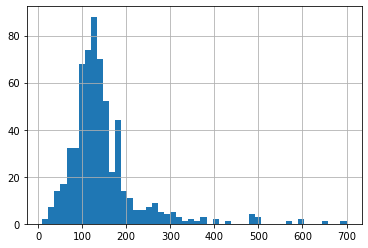

In [40]:
# showing the distribution of 'LoanAmount' column
df['LoanAmount'].hist(bins=50)

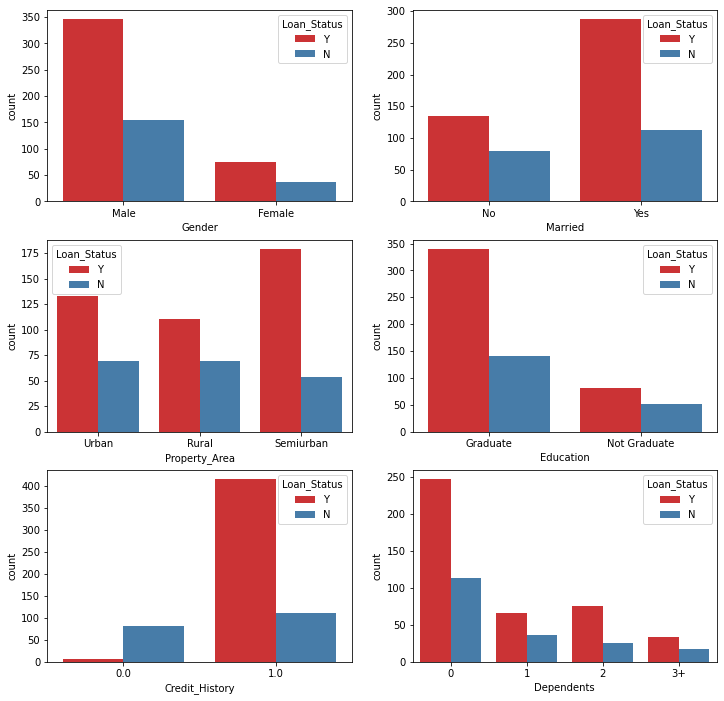

In [41]:
# showing the distributions between categorical columns
x = ['Gender','Married','Property_Area','Education','Credit_History','Dependents']
fig,axes = plt.subplots(3,2,figsize=(12,12))   
for i,j in enumerate(x):
    row,col = i//2,i%2
    sns.countplot(x=j,data=df,hue='Loan_Status',ax=axes[row,col], palette = 'Set1')

<AxesSubplot:xlabel='Loan_Status', ylabel='ApplicantIncome'>

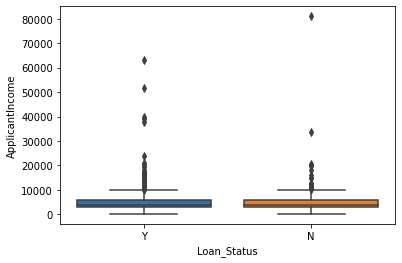

In [42]:
# connection between 'Loan Status' and 'ApplicantIncome'
sns.boxplot(y='ApplicantIncome',x= 'Loan_Status',data=df)

<AxesSubplot:xlabel='Loan_Status', ylabel='LoanAmount'>

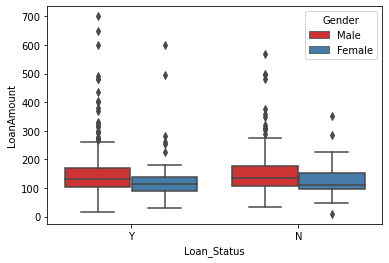

In [43]:
# connection between 'Loan Status' and 'LoanAmount' by Gender
sns.boxplot(y="LoanAmount",x='Loan_Status',hue='Gender',data=df, palette="Set1")

In [44]:
# converting categorical variables into numeric
le = LabelEncoder()
for i in categorical_vars:
    df[i] = le.fit_transform(df[i])

# df.head()

In [45]:
df.head()
# after converting categorical variables into numeric we have the following results:
# in Gender column Male is 1, Female is 0
# in Married and Self_Employed columns Yes is 1, No is 0
# in Education column Graduate is 0, Not Graduate is 1
# in Property_Area column Rural is 0, Semiurban is 1, Urban is 2
# in Loan_Status column Y is 1, N is 0

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,146,360,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128,360,1.0,0,0
2,1,1,0,0,1,3000,0.0,66,360,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120,360,1.0,2,1
4,1,0,0,0,0,6000,0.0,141,360,1.0,2,1


In [46]:
# defining the dependent variable by taking Loan_Status column from the data
y = df["Loan_Status"]

# dropping the dependent variable(Loan_Status column) from the data
df.drop("Loan_Status", axis='columns', inplace=True)

# defining the independent variables by taking all columns from the data
x = df

# splitting the data into train and test parts by 80% and 20% proportions respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 24)

In [47]:
# standardizing the data in order to have 0 centered values, which will make calculations faster and columns more comparable
def Std(x_train,x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
    x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
    return [x_train_scaled,x_test_scaled]

std =  Std(x_train, x_test)

In [48]:
# seperating standardized data
x_train = std[0]
x_test = std[1]
# there is no need to standardize y_train and y_test because they have only 0 and 1 final values

In [49]:
# defining metrics function, which will calculate probability and accuracy of our predictions

def metrics(model,x_train,y_train,x_test,y_test):
    roc_train = round(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1], average="weighted")*100,2)
    roc_test = round(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1], average="weighted")*100,2)
    print ("ROC_AUC Train: " + str(roc_train))
    print ("ROC_AUC Test: " + str(roc_test))
    traina = round(model.score(x_train,y_train)*100,2)
    testa = round(model.score(x_test,y_test)*100,2)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    recall1 = round(recall_score(y_test,y_test_pred)*100,2)
    prec1 = round(precision_score(y_test,y_test_pred)*100,2)
    y_test_0 = [0 if i ==1 else 1 for i in y_test ]
    y_test_pred_0 = [0 if i ==1 else 1 for i in y_test_pred]
    recall0 = round(recall_score(y_test_0,y_test_pred_0)*100,2)
    prec0 = round(precision_score(y_test_0,y_test_pred_0)*100,2)
    F1_1 = round(f1_score(y_test,y_test_pred)*100,2)
    F1_0 = round(f1_score(y_test_0,y_test_pred_0)*100,2)

    return [[roc_train, roc_test],[traina,testa],[recall1,prec1],[recall0,prec0],[F1_1,F1_0]]

In [50]:
# defining parameters for logistic regression 
par = {"random_state":42, "class_weight":"balanced","n_jobs":-1,"solver":"saga","max_iter": 1000,
"C": 0.1}
# penalty = l1 is for lasso regression and penalty = l2 is for ridge regression
params ={"lasso":{**par,**{"penalty":"l1"}},"ridge":{**par,**{"penalty":"l2"}}}

In [51]:
# creating the model using lasso regression and giving parameters, 

# model_logit = LogisticRegression(**params["lasso"])
# model_logit.fit(x_train,y_train)
# roc = metrics(model_logit,x_train,y_train,x_test,y_test)
# roc

# comparing two results of ridge and lasso , we found out that ridge is more benficial

In [52]:
# creating the model using ridge regression and giving parameters 
model_logit = LogisticRegression(**params["ridge"])
model_logit.fit(x_train,y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42, solver='saga')

In [53]:
# after checking the accuracies of train and test in case of ridge regression, we conclude that the model does not have high accuracy with logistic regression
roc = metrics(model_logit,x_train,y_train,x_test,y_test)
roc

ROC_AUC Train: 75.84
ROC_AUC Test: 78.65


[[75.84, 78.65], [78.82, 82.11], [93.26, 83.84], [52.94, 75.0], [88.3, 62.07]]

In [54]:
# checking coefficients to see which variables have the highest impact on our model
# Credit_History have a high role in prediction
model_logit.coef_

array([[-1.68822710e-02,  2.15606095e-01,  5.37209677e-02,
        -1.19961634e-01,  7.30650541e-03, -6.59892042e-04,
        -9.76735702e-02, -1.15624471e-01, -1.09572034e-01,
         1.06935817e+00,  8.35748392e-02]])

In [55]:
# now we will try to creat our model with Random Forest
# in case of Random Forest there is no need to standardize the data
# so lets split our data again, in order to have not standardized data

# splitting the data into train and test parts by 80% and 20% proportions respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 24)

In [56]:
# applying RFC model
model_tree = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10, min_samples_split=4, min_samples_leaf=40, max_features= 2, bootstrap=True,random_state=42,class_weight="balanced")

model_tree.fit(x_train,y_train)

# calling metrics in order to see the accuracy of our predictions
roc = metrics(model_tree,x_train,y_train,x_test,y_test)
roc

ROC_AUC Train: 82.45
ROC_AUC Test: 81.99


[[82.45, 81.99],
 [77.19, 79.67],
 [88.76, 84.04],
 [55.88, 65.52],
 [86.34, 60.32]]

**Additional**

In [57]:
# below parts of the code were used for grid search to find the best hyperparameters for the model, 
# however it did not work as the difference between train and test accuracy was very big

In [58]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [59]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(x_train, y_train)

In [60]:
# rf_random.best_params_

In [61]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [40, 50, 60, 70],
#     'max_features': [2, 3],
#     'min_samples_leaf': [1, 2, 3],
#     'min_samples_split': [3, 5, 7],
#     'n_estimators': [100, 200, 300, 1000]
# }
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(x_train, y_train)

In [62]:
# grid_search.best_params_